In [ ]:
# Required for Google Colab

!pip install rasterio
!pip install zarr
!pip install xarray[complete]

from google.colab import drive
drive.mount('/content/drive')

import os

# Root of project
os.chdir('/content/drive/MyDrive/Final Submission Files')

# Improvements folder
os.chdir('Models/Improvements')

In [1]:
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
from math import log10, floor
import numpy as np
import datetime
import seaborn as sns
from scipy import stats
import pandas as pd
import glob
import tqdm
import os
import random
import pickle
import copy 
from xgrid_utils import calc_spatial_integral

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam

from model import *

def get_trainable_params(model):
    return np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])

def round_to_1(x):
    return round(x, -int(floor(log10(abs(x)))))

/Users/Zach/miniforge3/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
# Read spatial and extent data
spatial_ds = xr.open_zarr('../../Data/ds_norm_coarsened_4x.zarr', consolidated=False)
extents = xr.open_dataarray('../../Data/extents.nc')

/Users/Zach/miniforge3/lib/python3.9/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
# Ex. get all results

save_dirs = [
    '../../Results/Improvements/8/',
    '../../Results/Improvements/9/',
    '../../Results/Improvements/10/',
    '../../Results/Improvements/11/',
    '../../Results/Improvements/12/',
]
for save_dir in save_dirs:
    model_names = [os.path.basename(f).split('.')[0] for f in glob.glob(save_dir + '/*T.p')]

    results = pd.DataFrame()

    # Load results
    for model_name in tqdm.tqdm(model_names):
        model = Spatial()
        model.load(model_name, save_dir, load_model=False)
        model.create_model(**model.model_params)


        def round_to_1(x):
            return round(x, -int(floor(log10(abs(x)))))

        # Invert the de-deseasonalizing
        y_pred_test_inv = model.reseasonalize(model.data['y_pred_test'].flatten(),
                                            model.data['climatologies_test'])
        y_true_inv = model.reseasonalize(model.data['y_extent_test'].flatten(),
                                        model.data['climatologies_test'])

        df = copy.copy(model.model_params)
        df['RMSPE_NN'] = rmspe(y_pred_test_inv, y_true_inv)
        df['MAPE_NN'] = mape(y_pred_test_inv, y_true_inv)
        df['RMSPE_Clim'] = rmspe(model.data['climatologies_test'], y_true_inv)
        df['MAPE_Clim'] = mape(model.data['climatologies_test'], y_true_inv)

        df['Timesteps'] = model_name.split('_')[-1]
        df['Name'] = save_dir + model_name
        df['Params'] = get_trainable_params(model.model)
        df['Image Size'] = model.model.input_shape[0][2:4]

        for l1l2 in ['convlstm_kernel_reg', 'lstm_kernel_reg']:
            df[l1l2] = (round_to_1(df[l1l2].l1.item()), round_to_1(df[l1l2].l2.item()))

        df = pd.DataFrame({k: [v] for k, v in df.items()})

        if results.empty:
            results = df
        else:
            results = results.append(df)

    results.to_csv(save_dir + 'results.csv', index=False)

  0%|                                                    | 0/13 [00:00<?, ?it/s]2022-04-18 15:57:36.346559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-18 15:57:36.347175: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.07s/it]


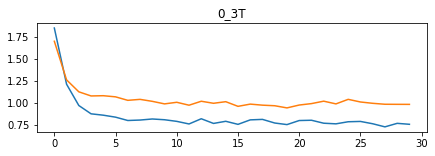

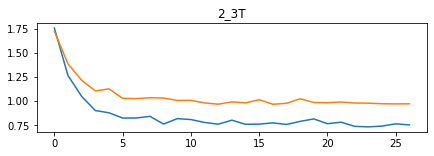

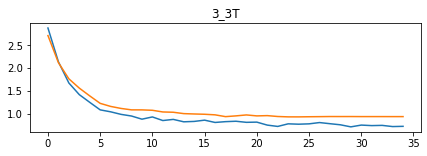

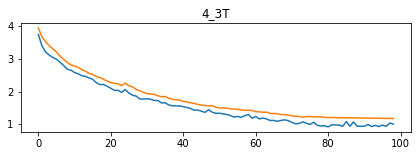

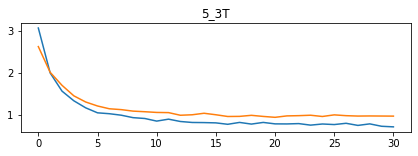

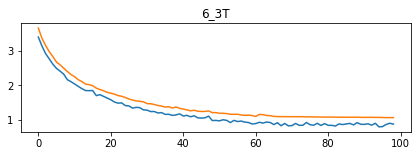

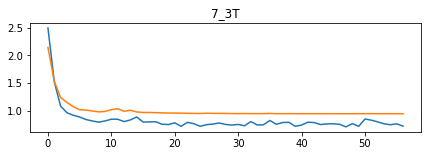

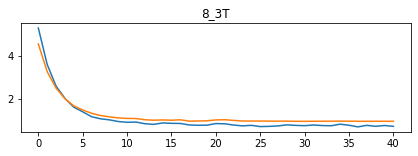

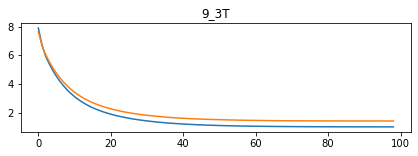

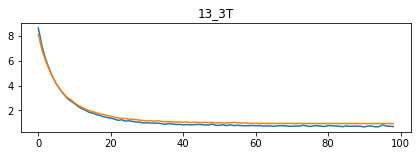

In [4]:
# Loss curves
save_dir = '../../Results/Improvements/12/'
model_names = [os.path.basename(f).split('.')[0] for f in glob.glob(save_dir + '/*T.p')]

results = pd.DataFrame()

# Load results
for model_name in model_names:
    model = Spatial()
    model.load(model_name, save_dir, load_model=False)
    plt.figure(figsize=(7, 2))
    plt.plot(model.history['loss'][1:])
    plt.plot(model.history['val_loss'][1:])
    plt.title(model_name)

In [5]:
# Put all results in dataframe
results = pd.concat([
    pd.read_csv('../../Results/Improvements/8/results.csv'),
    pd.read_csv('../../Results/Improvements/9/results.csv'),
    pd.read_csv('../../Results/Improvements/10/results.csv'),
    pd.read_csv('../../Results/Improvements/11/results.csv'),
    pd.read_csv('../../Results/Improvements/12/results.csv'),
])
blacklist = ['RMSPE_NN', 'MAPE_NN', 'RMSPE_Clim', 'MAPE_Clim', 'Params', 'Name']
results = results.drop_duplicates(keep='first', subset=[col for col in results.columns if col not in blacklist])

results.to_csv('../../Results/Improvements/all_results.csv')

results = (results[[col for col in results.columns if (len(results[col].unique()) != 1) or ('Clim' in col)]]).sort_values('RMSPE_NN').reset_index(drop=True)
results

,num_convlstm,convlstm_filters,convlstm_kernels,convlstm_dropout,convlstm_rec_dropout,convlstm_kernel_reg,num_conv2d,conv2d_filters,conv2d_kernels,num_lstm,...,lstm_kernel_reg,GAP,RMSPE_NN,MAPE_NN,RMSPE_Clim,MAPE_Clim,Timesteps,Name,Params,Image Size
0,2,"(128, 128)","((3, 3), (1, 1))",0.1,0.1,"(0.0001, 0.0001)",2,"(64, 1)","((3, 3), (3, 3))",2,...,"(0.0001, 0.0001)",False,4.884058,3.288630,8.699484,4.645978,3T,../../Results/Improvements/8/1_3T,1368962,"(25, 360)"
1,3,"(64, 64, 64)","((5, 5), (3, 3), (1, 1))",0.1,0.1,"(0.0001, 0.0001)",2,"(64, 1)","((3, 3), (3, 3))",2,...,"(0.0001, 0.0001)",True,5.068509,3.283237,8.699484,4.645978,3T,../../Results/Improvements/10/3_3T,951746,"(25, 360)"
2,2,"(64, 64)","((3, 3), (1, 1))",0.1,0.1,"(0.0001, 0.0001)",2,"(64, 1)","((3, 3), (3, 3))",2,...,"(0.0001, 0.0001)",False,5.104979,3.359350,8.699484,4.645978,3T,../../Results/Improvements/8/0_3T,746882,"(25, 360)"
3,2,"(128, 128)","((3, 3), (1, 1))",0.1,0.1,"(0.0001, 0.0001)",2,"(64, 1)","((3, 3), (3, 3))",2,...,"(0.0001, 0.0001)",False,5.150937,3.532749,8.911507,4.801169,7T,../../Results/Improvements/9/1_7T,1368962,"(25, 360)"
4,2,"(32, 32)","((3, 3), (1, 1))",0.1,0.1,"(0.0001, 0.0001)",2,"(64, 1)","((3, 3), (3, 3))",2,...,"(0.0001, 0.0001)",True,5.215189,3.373923,8.699484,4.645978,3T,../../Results/Improvements/10/2_3T,140610,"(25, 360)"
5,2,"(32, 32)","((3, 3), (1, 1))",0.1,0.1,"(0.0001, 0.0001)",2,"(64, 1)","((3, 3), (3, 3))",2,...,"(0.0001, 0.0001)",False,5.244044,3.451316,8.699484,4.645978,3T,../../Results/Improvements/8/2_3T,571010,"(25, 360)"
6,2,"(128, 128)","((3, 3), (1, 1))",0.1,0.1,"(0.0001, 0.0001)",2,"(64, 1)","((3, 3), (3, 3))",2,...,"(0.0001, 0.0001)",False,5.328689,3.432184,8.804404,4.720148,5T,../../Results/Improvements/9/1_5T,1368962,"(25, 360)"
7,2,"(64, 64)","((3, 3), (1, 1))",0.1,0.1,"(0.0001, 0.0001)",2,"(64, 1)","((3, 3), (3, 3))",2,...,"(0.0001, 0.0001)",False,5.480218,3.525927,8.911507,4.801169,7T,../../Results/Improvements/9/0_7T,746882,"(25, 360)"
8,3,"(64, 64, 64)","((5, 5), (3, 3), (1, 1))",0.1,0.1,"(0.0001, 0.0001)",2,"(64, 1)","((3, 3), (3, 3))",2,...,"(0.0001, 0.0001)",False,5.487683,3.474723,8.699484,4.645978,3T,../../Results/Improvements/8/7_3T,1287682,"(25, 360)"
9,3,"(64, 64, 64)","((5, 5), (3, 3), (1, 1))",0.1,0.1,"(0.0001, 0.0001)",2,"(64, 1)","((3, 3), (3, 3))",2,...,"(0.0001, 0.0001)",False,5.488986,3.524844,8.911507,4.801169,7T,../../Results/Improvements/9/3_7T,1287682,"(25, 360)"


In [6]:
# Top five
with open('top-five.tex', 'w') as tf:
     tf.write(results.head(5).T.to_latex())
        
results.head(5).T

,0,1,2,3,4
num_convlstm,2,3,2,2,2
convlstm_filters,"(128, 128)","(64, 64, 64)","(64, 64)","(128, 128)","(32, 32)"
convlstm_kernels,"((3, 3), (1, 1))","((5, 5), (3, 3), (1, 1))","((3, 3), (1, 1))","((3, 3), (1, 1))","((3, 3), (1, 1))"
convlstm_dropout,0.1,0.1,0.1,0.1,0.1
convlstm_rec_dropout,0.1,0.1,0.1,0.1,0.1
convlstm_kernel_reg,"(0.0001, 0.0001)","(0.0001, 0.0001)","(0.0001, 0.0001)","(0.0001, 0.0001)","(0.0001, 0.0001)"
num_conv2d,2,2,2,2,2
conv2d_filters,"(64, 1)","(64, 1)","(64, 1)","(64, 1)","(64, 1)"
conv2d_kernels,"((3, 3), (3, 3))","((3, 3), (3, 3))","((3, 3), (3, 3))","((3, 3), (3, 3))","((3, 3), (3, 3))"
num_lstm,2,2,2,2,2


## Influence of parameter selection

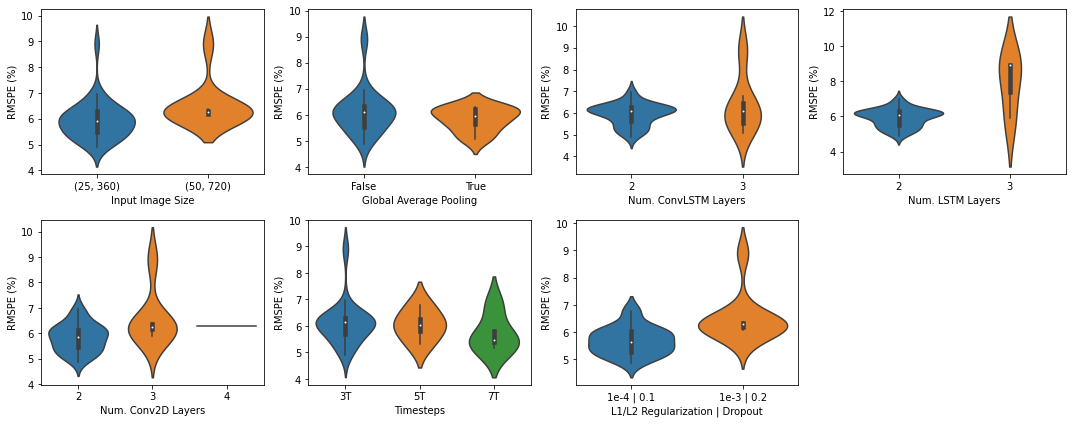

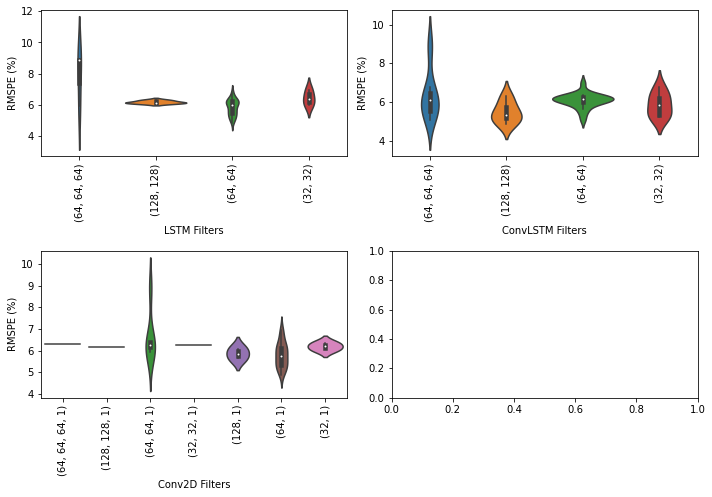

In [7]:
# Note that 'convlstm_dropout' encapsulates all of the dropouts + increase in regularization

labels = {
    'GAP': 'Global Average Pooling',
    'Image Size': 'Input Image Size',
    'num_convlstm': 'Num. ConvLSTM Layers',
    'num_lstm': 'Num. LSTM Layers',
    'num_conv2d': 'Num. Conv2D Layers',
    'Timesteps': 'Timesteps',
    'convlstm_dropout': 'L1/L2 Regularization | Dropout',
    'lstm_units': 'LSTM Filters',
    'convlstm_filters': 'ConvLSTM Filters',
    'conv2d_filters': 'Conv2D Filters',
}

fig, axs = plt.subplots(2, 4, figsize=(15, 6))
params = ['Image Size', 'GAP', 'num_convlstm', 'num_lstm', 'num_conv2d',
          'Timesteps', 'convlstm_dropout']
for i, param in enumerate(params):
    if param == 'Timesteps':
        kwargs = {'order': ['3T', '5T', '7T']}
    else:
        kwargs = {}
    
    ax = axs.flatten()[i]
    sns.violinplot(x=results[param], y=results['RMSPE_NN'], ax=ax, **kwargs)
    ax.set_ylabel('RMSPE (%)')
    ax.set_xlabel(labels[param])

# Manual stuff
ax.set_xticklabels(['1e-4 | 0.1', '1e-3 | 0.2'])
fig.delaxes(axs[1][3])
plt.tight_layout()


fig, axs = plt.subplots(2, 2, figsize=(10, 7))
params = ['lstm_units', 'convlstm_filters', 'conv2d_filters']
for i, param in enumerate(params):
    if param == 'lstm_units':
        kwargs = {'order': ['(64, 64, 64)', '(128, 128)', '(64, 64)', '(32, 32)']}
    elif param == 'convlstm_filters':
        kwargs = {'order': ['(64, 64, 64)', '(128, 128)', '(64, 64)', '(32, 32)']}
    elif param == 'conv2d_filters':
        kwargs = {'order': ['(64, 64, 64, 1)', '(128, 128, 1)', '(64, 64, 1)', '(32, 32, 1)', '(128, 1)', '(64, 1)', '(32, 1)']}
    else:
        kwargs = {}
        
    ax = axs.flatten()[i]
    sns.violinplot(x=results[param], y=results['RMSPE_NN'], ax=ax, **kwargs)
    ax.set_ylabel('RMSPE (%)')
    ax.set_xlabel(labels[param])
    
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        # label.set_ha('left')


plt.tight_layout()

<AxesSubplot:xlabel='GAP', ylabel='RMSPE_NN'>

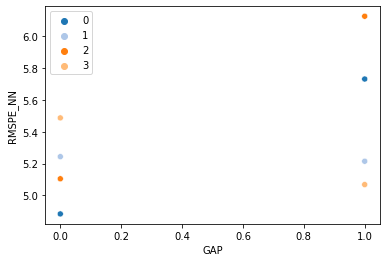

In [8]:
# Another attempt at visualizing -- failure
param = 'GAP'
blacklist = ['RMSPE_NN', 'MAPE_NN', 'RMSPE_Clim', 'MAPE_Clim', 'Params', 'Name'] + [param]
non_blacklist = [col for col in results.columns if col not in blacklist]

dups = results[results[non_blacklist].duplicated(keep=False)]

dfs = [df for _, df in dups.groupby(non_blacklist)]
for i, tmp in enumerate(dfs):
    tmp.index = [i] * len(tmp)

df = pd.concat([df[['GAP', 'RMSPE_NN']] for df in dfs])
sns.scatterplot(x=df[param], y=df.RMSPE_NN, hue=df.index, palette='tab20')

## Plot model predictions

../../Results/Improvements/8/1_3T
             NN  Climatology
RMSPE  4.884058     8.699484
MAPE   3.288630     4.645978


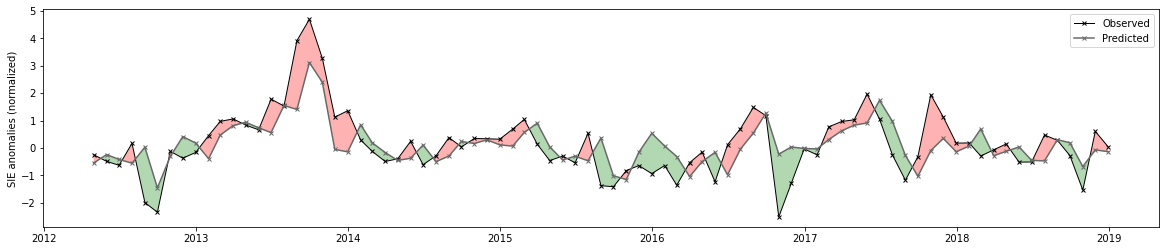

../../Results/Improvements/10/3_3T
             NN  Climatology
RMSPE  5.068509     8.699484
MAPE   3.283237     4.645978


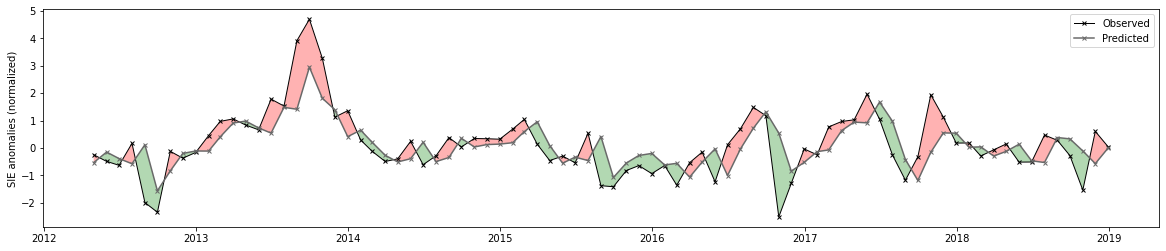

../../Results/Improvements/8/0_3T
             NN  Climatology
RMSPE  5.104979     8.699484
MAPE   3.359350     4.645978


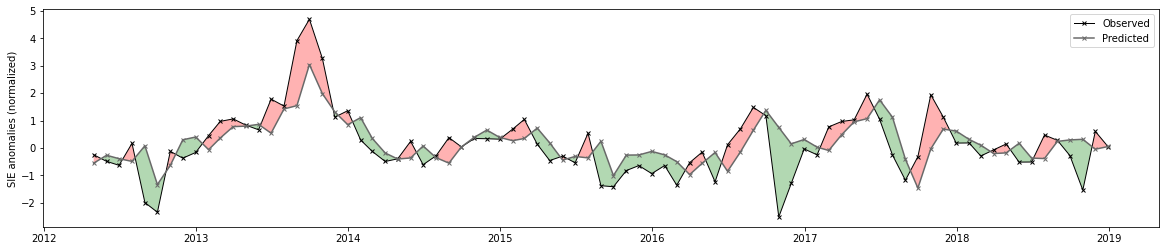

../../Results/Improvements/9/1_7T
             NN  Climatology
RMSPE  5.150937     8.911507
MAPE   3.532749     4.801169


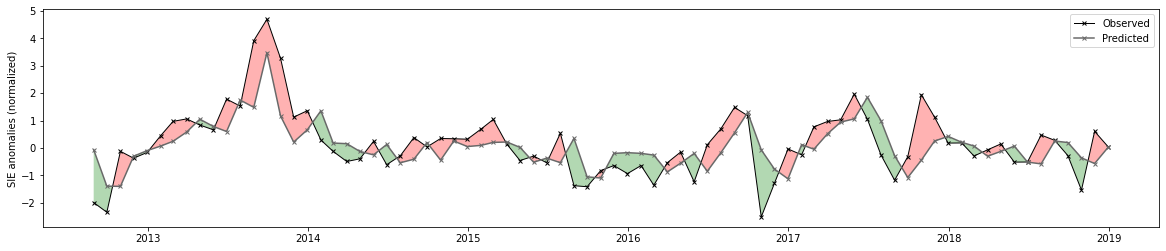

../../Results/Improvements/10/2_3T
             NN  Climatology
RMSPE  5.215189     8.699484
MAPE   3.373923     4.645978


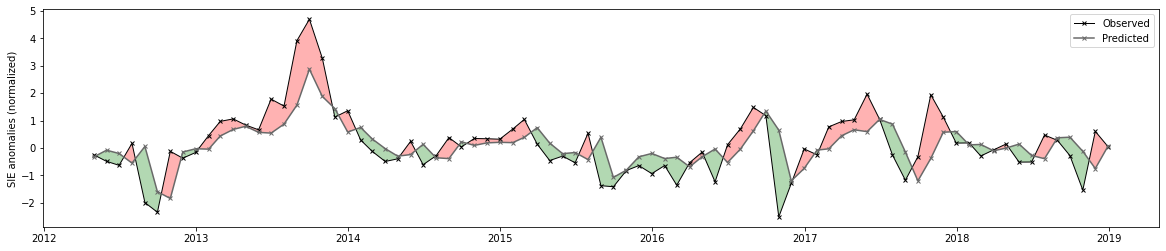

In [9]:
# Ex. load model results & print + plot
best_models = [
    '../../Results/Improvements/8/1_3T',
    '../../Results/Improvements/10/3_3T',
    '../../Results/Improvements/8/0_3T',
    '../../Results/Improvements/9/1_7T',
    '../../Results/Improvements/10/2_3T',
]

inverted = False

# Load results
for model_name in best_models:
    print(model_name)
    model = Spatial()
    model.load(model_name, '', load_model=False)

    # Invert the de-deseasonalizing
    y_pred_test_inv = model.reseasonalize(model.data['y_pred_test'].flatten(),
                                        model.data['climatologies_test'])
    y_true_inv = model.reseasonalize(model.data['y_extent_test'].flatten(),
                                    model.data['climatologies_test'])

    # Get metrics & print
    results_df = pd.DataFrame({
        'NN': [rmspe(y_pred_test_inv, y_true_inv),
            mape(y_pred_test_inv, y_true_inv)],
        'Climatology': [rmspe(model.data['climatologies_test'], y_true_inv),
                        mape(model.data['climatologies_test'], y_true_inv)],
    }, index=['RMSPE', 'MAPE'])
    print(results_df)

    # Plot 
    # fig, ax = plt.subplots(figsize=(8, 3.5), dpi=120)
    if not inverted:
        ax = plot_timeseries(model.data['y_pred_test'].flatten(), model.data['y_extent_test'].flatten(), model.data['dates_test'])#, ax=ax)
        ax.set_ylabel('SIE anomalies (normalized)')
    else:
        ax = plot_timeseries(y_pred_test_inv, y_true_inv, model.data['dates_test'], ax=ax)
        ax.set_ylabel('SIE [kmx\u00b2]')
    
    # For adding lines at July
    # for vline in model.data['dates_test'][model.data['dates_test'].month == 7].values:
    #     ax.axvline(vline, c='r', ls='--')
    # ax.axhline(0)
    plt.show()

## View RMSPE by month

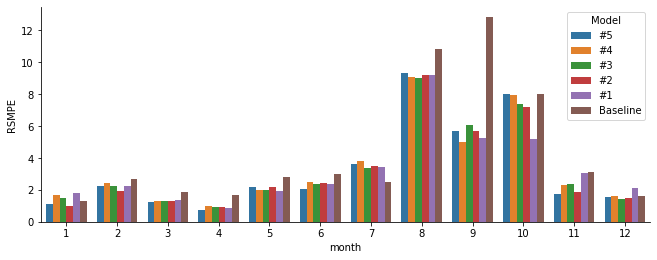

In [10]:
def get_rmspe_by_month(y_true, y_pred, dates):
    rmspes = [rmspe(t, p) for t, p in zip(y_true, y_pred)]
    da = xr.DataArray(rmspes, dims=['time'], coords={'time': dates})  # Create time-aware array
    da = da.groupby('time.month').mean()
    return da

def plot_rmspe_by_month(y_true, y_clim, y_pred, dates):
    nn = get_rmspe_by_month(y_true, y_pred, dates)
    clim = get_rmspe_by_month(y_true_inv, y_clim, model.data['dates_test'])
    rmpse_by_month = pd.merge(
        nn.to_dataframe(name='Model'),
        clim.to_dataframe(name='Climatology'),
        how='outer', left_index=True, right_index=True
    )
    rmpse_by_month = pd.melt(rmpse_by_month.reset_index(), id_vars="month", var_name='Model', value_name='RSMPE')

    ax = sns.catplot(x='month', y='RSMPE', hue='Model', data=rmpse_by_month, kind='bar')
    ax.fig.set_size_inches(8, 3)
    return ax

def plot_rmspe_by_month_multiple(y_true, y_clim, y_pred, dates, names):
    clim = get_rmspe_by_month(y_true[0], y_clim[0], model.data['dates_test'])
    rmpse_by_month = clim.to_dataframe(name='Baseline')
    
    for i in range(len(y_true)):
        nn = get_rmspe_by_month(y_true[i], y_pred[i], dates[i])
        rmpse_by_month = pd.merge(
            nn.to_dataframe(name=names[i]),
            rmpse_by_month,
            how='outer', left_index=True, right_index=True
        )
    rmpse_by_month = pd.melt(rmpse_by_month.reset_index(), id_vars="month", var_name='Model', value_name='RSMPE')

    ax = sns.catplot(x='month', y='RSMPE', hue='Model', data=rmpse_by_month, kind='bar', legend_out=False)#, palette='tab10')
    ax.fig.set_size_inches(8, 3)
    return ax

# Best models in order
hierarch = {best_models[i]: f'#{i + 1}' for i in range(len(best_models))}

# Multiple models one plot
y_true_list, y_pred_list, y_clim_list, dates_list = [], [], [], []
for i, model_name in enumerate(best_models):
    model = Spatial()
    model.load(model_name, '', load_model=False)

    # Invert the de-deseasonalizing
    y_pred_list.append(model.reseasonalize(model.data['y_pred_test'].flatten(),
                                        model.data['climatologies_test']))
    y_true_list.append(model.reseasonalize(model.data['y_extent_test'].flatten(),
                                    model.data['climatologies_test']))
    y_clim_list.append(model.data['climatologies_test'])
    dates_list.append(model.data['dates_test'])
    

ax = plot_rmspe_by_month_multiple(y_true=y_true_list,
                             y_clim=y_clim_list,
                             y_pred=y_pred_list,
                             dates=dates_list,
                             names=[hierarch[m] for m in best_models])
ax.fig.set_size_inches(10, 3.5)

In [11]:
# Ensemble??

best_models = list(results.head(5).Name)

def create_dataarray(y, dates):
    return xr.DataArray(y, dims=['time'], coords={'time': dates})

# Get ground truth from arbitrary model
model = Spatial()
model.load(best_models[0], '', load_model=False)
ensemble = create_dataarray(
    y=model.reseasonalize(model.data['y_extent_test'].flatten(), model.data['climatologies_test']),
    dates=model.data['dates_test']
)
ensemble = ensemble.to_dataset(name='y_true')
ensemble['y_clim'] = create_dataarray(model.data['climatologies_test'], model.data['dates_test'])

for i, model_name in enumerate(best_models):
    model = Spatial()
    model.load(model_name, '', load_model=False)

    # Invert the de-deseasonalizing
    ensemble[model_name] = create_dataarray(
        y=model.reseasonalize(model.data['y_pred_test'].flatten(), model.data['climatologies_test']),
        dates=model.data['dates_test']
    )
    
ensemble['y_mean'] = y_ensemble=ensemble[best_models].to_array(dim='new').mean('new')
ensemble = ensemble.drop(best_models)

results_df = pd.DataFrame({
    'NN': [rmspe(ensemble.y_mean, ensemble.y_true).values,
        mape(ensemble.y_mean, ensemble.y_true).values],
    'Climatology': [rmspe(ensemble.y_clim, ensemble.y_true).values,
                    mape(ensemble.y_clim, ensemble.y_true).values],
}, index=['RMSPE', 'MAPE'])

results_df

,NN,Climatology
RMSPE,4.973107002760355,8.699484480824045
MAPE,3.277613396785083,4.645978212641726


## Sensitivity Analysis

In [ ]:
# Create new datasets
def shuffle_ndarray(arr):
    arr_shape = arr.shape

    arr = arr.flatten()
    random.shuffle(arr)
    return arr.reshape(arr_shape)

def shuffle_along_dim(arr, i, axis=0):
    arr_i = shuffle_ndarray(np.moveaxis(arr, axis, 0)[i])
    arr = np.moveaxis(arr, axis, 0)
    arr[i] = arr_i
    arr = np.moveaxis(arr, 0, axis)
    return arr

var_list = list(spatial_ds.data_vars)

arrays_shuffled = [shuffle_along_dim(copy.deepcopy(np.array(spatial_ds.to_array())), i, axis=0) for i in range(len(var_list))]
all_spatial_ds_shuffled = [copy.deepcopy(spatial_ds)]
for i, arr in enumerate(arrays_shuffled):
    spatial_ds_shuffled = copy.deepcopy(spatial_ds)
    for j, var_ in enumerate(var_list):
        spatial_ds_shuffled[var_].data = arr[j]
    all_spatial_ds_shuffled.append(spatial_ds_shuffled)

In [ ]:
results = pd.DataFrame()

# Load results
for model_name in tqdm.tqdm(best_models):
    model = Spatial()
    # model.load(model_name, '', load_model=True)
    model.model = keras.models.load_model(model_name + '_model.p')
    
    for data_var, spatial_ds_shuffled in zip(['all'] + var_list, all_spatial_ds_shuffled):
        data = model.process_data(spatial_ds_shuffled,
                                  extents,
                                  num_timesteps=int(model_name[-2]),
                                  deseasonalize_type=1,
                                  test_size=0.2)



        # Get predictions & add to data dictionary
        model.data = copy.deepcopy(data)
        model.data['y_pred_test'] = model.model.predict([data['X_grid_test'], data['X_extent_test']])

        # Invert the de-deseasonalizing
        y_pred_test_inv = model.reseasonalize(model.data['y_pred_test'].flatten(),
                                            model.data['climatologies_test'])
        y_true_inv = model.reseasonalize(model.data['y_extent_test'].flatten(),
                                        model.data['climatologies_test'])

        df = {}
        df['RMSPE_NN'] = rmspe(y_pred_test_inv, y_true_inv)
        df['MAPE_NN'] = mape(y_pred_test_inv, y_true_inv)
        df['RMSPE_Clim'] = rmspe(model.data['climatologies_test'], y_true_inv)
        df['MAPE_Clim'] = mape(model.data['climatologies_test'], y_true_inv)
        df['var'] = data_var
        df['model_name'] = model_name

        df = pd.DataFrame({k: [v] for k, v in df.items()})

        if results.empty:
            results = df
        else:
            results = results.append(df)

In [ ]:
# results.to_csv('../Results/sensitivity_analysis.csv', index=False)
sa_results = pd.read_csv('../Results/sensitivity_analysis.csv')
hierarch = {best_models[i]: f'#{i + 1}' for i in range(len(best_models))}
sa_results['model_name'] = [hierarch[m] for m in sa_results['model_name']]

In [ ]:
delta_rmspe = {}
for model_name, df in sa_results.groupby('model_name'):
    df = df.set_index('var')
    delta_rmspe[model_name] = np.array(df[df.index!='all'].RMSPE_NN) - df.loc['all'].RMSPE_NN
delta_rmspe = pd.DataFrame(delta_rmspe)
delta_rmspe.index = df.index[1:]
delta_rmspe['Average'] = delta_rmspe.mean(axis=1)

plt.figure(figsize=(6, 2), dpi=180)
sns.heatmap(delta_rmspe.T, cmap=sns.diverging_palette(20, 120, as_cmap=True), center=0)